# Week 11 - GAN

# November 2, 2023.


In [47]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [48]:
!pip install plotly

In [49]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [50]:
# Enter BUFFER_SIZE so that the sample size is a multiple of BATCH_SIZE
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (60000, 28, 28)
Number of labels: 60000


In [51]:
# Data normalization
x_train = x_train / 255
x_test = x_test / 255

# We form tensors for training and test samples
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Splitting the training sample into BATCHES
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

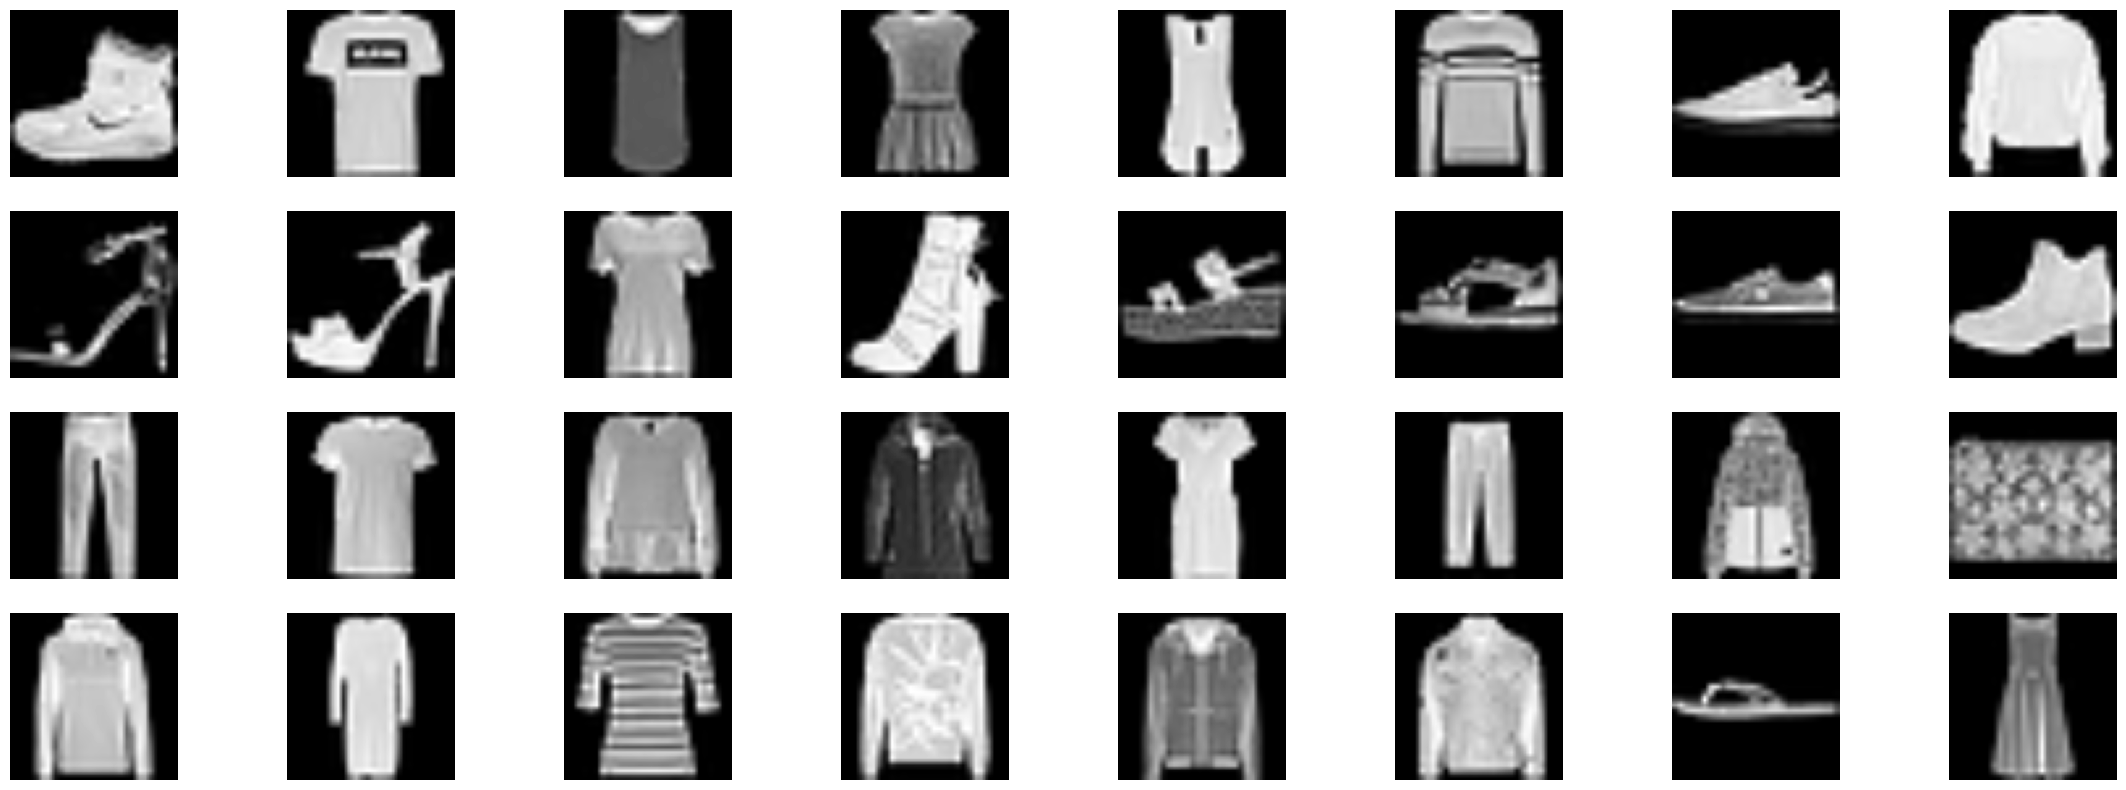

In [52]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    counter += 1
    if counter == cnt_imgs:
        break

## 1.Build the GAN model to generate a new dataset.


In [53]:
# loss function
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [58]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)
# We will feed a vector of independent random variables of the hidden dimension to the input of the generator
hidden_dim = [20, 50, 100]

In [59]:
# First, let's create a generator model
def gen_model(hidden_dim):
    generator = Sequential(name='generator')
    generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
    generator.add(BatchNormalization())
    generator.add(Reshape((7, 7, 256)))  # got a tensor
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))
    generator.summary()
    generator.compile()

In [60]:
# next let's create a discriminator model
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                401472    
                                                                 
 dense_15 (Dense)            (None, 1)               

In [61]:
# compiling neural networks
generator1 = gen_model(hidden_dim[0])
generator2 = gen_model(hidden_dim[1])
generator3 = gen_model(hidden_dim[2])
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12544)             263424    
                                                                 
 batch_normalization_18 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_18 (Conv2  (None, 7, 7, 128)         819328    
 DTranspose)                                                     
                                                                 
 batch_normalization_19 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                         

In [62]:
# Generator and Discriminator training
@tf.function
def train_step((images) -> (float, float),hidden_dim, generator):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss

SyntaxError: Function parameters cannot be parenthesized (2381690960.py, line 3)

In [72]:
# the learning process for all epochs
def train(dataset,  EPOCHS, generator) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in  generator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)
    for hd in hidden_dim:
        for epoch in range(1, EPOCHS + 1):
            print(f'{epoch}/{EPOCHS}: ', end='')
            start = time.time()
            n = 0
            gen_loss_epoch = 0
            for image_batch in dataset:
                gen_loss, disc_loss = train_step(image_batch,hd,generator)
                gen_loss_epoch += K.mean(gen_loss)
                if (n % th == 0):
                    print('=', end='')
                n += 1
            print('>', end = ' ')
    
            history += [gen_loss_epoch / n]
            print(':Loss = ' + str(history[-1]))
            print(f'The time of the epoch {epoch}: {time.time() - start} second')
    return history

In [73]:
# Starting the learning process
gen_history = []
gen_history.append(train(train_dataset, 100, generator1))
gen_history.append(train(train_dataset, 150, generator2))
gen_history.append(train(train_dataset, 200, generator3))

1/100: 

TypeError: Binding inputs to tf.function `train_step` failed due to `too many positional arguments`. Received args: (<tf.Tensor: shape=(100, 28, 28, 1), dtype=float64, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       ...,


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])>, 20, None) and kwargs: {} for signature: (images).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


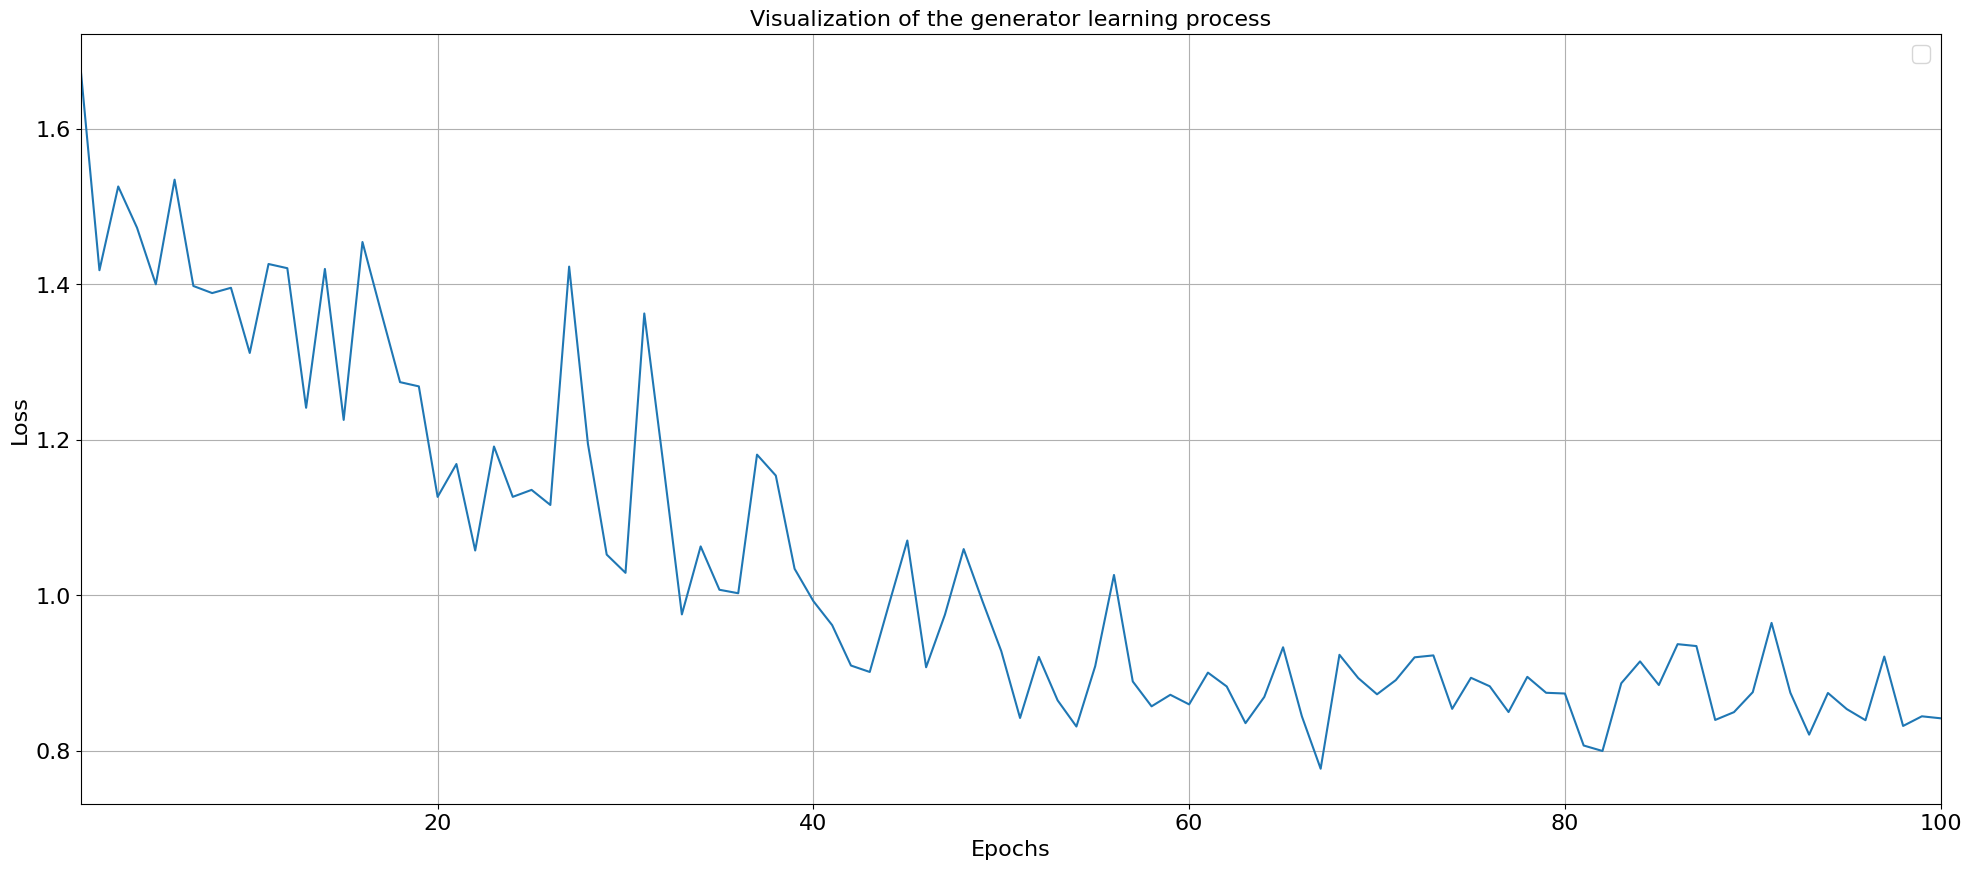

In [46]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, epoch + 1), gen_history[0])
plt.plot(np.arange(1, epoch + 1), gen_history[1])
plt.plot(np.arange(1, epoch + 1), gen_history[2])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)    
plt.xlim(1, epoch)
plt.legend(fontsize=16)
plt.show()